In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Define column names based on the observed structure
column_names = ["Time", "ID", "Positionx","Positionz","Positiony", "Yaw", "Up", "Right", "Down", "Left"]

# Read the CSV file without a header and assign column names
file_path = '/Users/yangfanzhou/Desktop/code/Experiment 1 data/PlayerPositions_71_240425_142931.csv'
data = pd.read_csv(file_path, header=None, names=column_names)

# 修改第一列的值，从0开始，每行递增0.5
data['Time'] = [i * 0.5 for i in range(len(data))]

# 去除 Positionx 和 Positiony 列中的括号
data['Positionx'] = data['Positionx'].astype(str).str.replace('(', '').str.replace(')', '')
data['Positiony'] = data['Positiony'].astype(str).str.replace('(', '').str.replace(')', '')

In [3]:
"""筛选满足条件的数据行的代码模版
# 找到传送的起始点
# 确保 Positiony 列的数据是数值类型
data['Positiony'] = pd.to_numeric(data['Positiony'], errors='coerce')

# 创建一个空的 DataFrame 来存储筛选结果
filtered_data = []

# 遍历 Positiony 列并筛选符合条件的行
for i in range(len(data) - 1):
    if -1 <= data.loc[i, 'Positiony'] <= 2 and abs(data.loc[i, 'Positiony'] - data.loc[i + 1, 'Positiony']) > 4:
        filtered_data.append(data.iloc[i])
        filtered_data.append(data.iloc[i + 1])

# 将结果转换为 DataFrame
filtered_data = pd.DataFrame(filtered_data)

# 重置索引
filtered_data.reset_index(drop=True, inplace=True)
"""

"筛选满足条件的数据行的代码模版\n# 找到传送的起始点\n# 确保 Positiony 列的数据是数值类型\ndata['Positiony'] = pd.to_numeric(data['Positiony'], errors='coerce')\n\n# 创建一个空的 DataFrame 来存储筛选结果\nfiltered_data = []\n\n# 遍历 Positiony 列并筛选符合条件的行\nfor i in range(len(data) - 1):\n    if -1 <= data.loc[i, 'Positiony'] <= 2 and abs(data.loc[i, 'Positiony'] - data.loc[i + 1, 'Positiony']) > 4:\n        filtered_data.append(data.iloc[i])\n        filtered_data.append(data.iloc[i + 1])\n\n# 将结果转换为 DataFrame\nfiltered_data = pd.DataFrame(filtered_data)\n\n# 重置索引\nfiltered_data.reset_index(drop=True, inplace=True)\n"

In [4]:
# 根据传送的起始点来给每行数据标label
# 确保清除信息后的 Positiony 和 Positionx 列的数据是数值类型
data['Positiony'] = pd.to_numeric(data['Positiony'], errors='coerce')
data['Positionx'] = pd.to_numeric(data['Positionx'], errors='coerce')

# 计算每行到原点 (0, 0) 的距离并新建一列 'distance'
data['Distance'] = np.sqrt(data['Positionx']**2 + data['Positiony']**2)

# 创建一个空的列表来存储需要标记的行索引
highlight_rows = []

# 遍历 Positiony 列并筛选符合条件的行
for i in range(len(data) - 1):
    if -1.5 < data.loc[i, 'Positiony'] and abs(data.loc[i, 'Distance'] - data.loc[i + 1, 'Distance']) > 5:
        highlight_rows.append(i)
        highlight_rows.append(i + 1)

# 创建一个新的列来存储标号
data['Label'] = 0

# 给数据行进行标号
current_label = 1
if highlight_rows:
    data.loc[:highlight_rows[0], 'Label'] = current_label
    for i in range(1, len(highlight_rows), 2):
        current_label += 1
        start_index = highlight_rows[i] + 1
        if i + 1 < len(highlight_rows):
            end_index = highlight_rows[i + 1]
            data.loc[start_index:end_index, 'Label'] = current_label
        else:
            data.loc[start_index:, 'Label'] = current_label
# 将 Label 列中间的0替换为前一个标号
for i in range(1, len(data)):
    if data.loc[i, 'Label'] == 0:
        data.loc[i, 'Label'] = data.loc[i + 1, 'Label']


In [5]:
# 删除六行数据(传送过程中的无用数据)

# 创建一个空的列表来存储需要清除信息的行索引
clear_rows = []

# 遍历 Positiony 列并筛选符合条件的行
for i in range(len(data) - 1):
    if -1 <= data.loc[i, 'Positiony'] <= 2 and abs(data.loc[i, 'Positiony'] - data.loc[i + 1, 'Positiony']) > 4:
        for j in range(max(0, i-5), i+1):
            clear_rows.append(j)

# 定义需要保留的列
columns_to_keep = ['Time', 'ID']

# 清除信息，但保留 Time 和 ID 信息
for row_index in clear_rows:
    for col in data.columns:
        if col not in columns_to_keep:
            data.at[row_index, col] = np.nan #''这是清除内容

In [6]:
# 计算速度 (positionx, positiony) 在每个时间单位的速度
# 创建新的速度列
data['Speed'] = np.nan

# 遍历 DataFrame 并计算速度
for i in range(1, len(data)):
    if pd.notna(data.at[i, 'Positionx']) and pd.notna(data.at[i, 'Positiony']) and \
       pd.notna(data.at[i-1, 'Positionx']) and pd.notna(data.at[i-1, 'Positiony']):
        # 计算距离
        dx = data.at[i, 'Positionx'] - data.at[i-1, 'Positionx']
        dy = data.at[i, 'Positiony'] - data.at[i-1, 'Positiony']
        distance = np.sqrt(dx**2 + dy**2)
        
        # 计算时间差
        dt = data.at[i, 'Time'] - data.at[i-1, 'Time']
        
        # 计算速度
        if dt != 0:
            speed = distance / dt
            data.at[i, 'Speed'] = speed

In [7]:
# 筛选出连续五秒（10个时间单位）速度都小于0.1的部分
zero_speed_indices = []

for i in range(len(data) - 10):
    if all(data.loc[i:i+9, 'Speed'] < 0.1):
        zero_speed_indices.extend(range(i, i+10))

# 过滤出这些行
zero_speed_data = data.loc[zero_speed_indices].drop_duplicates().reset_index(drop=True)

# 显示符合条件的DataFrame
# display(zero_speed_data)

In [8]:

# 筛选出速度大于2.5且距离大于8.5的行, 删除这些行以及他们所在的轨迹中所有之前行的数据
filtered_data = data[(data['Speed'] > 2.5) & (data['Distance'] > 8.5)]

# 找到这些行所在的Label
labels_to_filter = filtered_data['Label'].unique()

# 遍历每一个需要处理的Label
for label in labels_to_filter:
    label_data = data[data['Label'] == label]
    # 找到需要删除的最后一个索引
    max_index_to_delete = filtered_data[filtered_data['Label'] == label].index.max()
    # 保留 Time 和 ID 列的信息，其他列设为空
    for row_index in label_data[label_data.index <= max_index_to_delete].index:
        for col in data.columns:
            if col not in ['Time', 'ID']:
                data.at[row_index, col] = np.nan  # 设为空值 NaN

# 重置索引
data.reset_index(drop=True, inplace=True)


In [9]:
"""
# 筛选出完整的trajectory，即删除那些没有距离落在2.3以内和7以外的trajectory
data['Distance'] = pd.to_numeric(data['Distance'], errors='coerce')
# Step 1: Find the minimum and maximum distance for each trajectory
trajectory_stats = data.groupby('Label')['Distance'].agg(['min', 'max']).reset_index()
# Step 2: Identify incomplete trajectories
incomplete_trajectories = trajectory_stats[
    ~((trajectory_stats['min'] < 2.3) & (trajectory_stats['max'] > 7))
]['Label']

# Step 3: Set data to NaN for incomplete trajectories except for ID and Time
for label in incomplete_trajectories:
    data.loc[data['Label'] == label, data.columns.difference(['Time', 'ID'])] = np.nan
"""

"\n# 筛选出完整的trajectory，即删除那些没有距离落在2.3以内和7以外的trajectory\ndata['Distance'] = pd.to_numeric(data['Distance'], errors='coerce')\n# Step 1: Find the minimum and maximum distance for each trajectory\ntrajectory_stats = data.groupby('Label')['Distance'].agg(['min', 'max']).reset_index()\n# Step 2: Identify incomplete trajectories\nincomplete_trajectories = trajectory_stats[\n    ~((trajectory_stats['min'] < 2.3) & (trajectory_stats['max'] > 7))\n]['Label']\n\n# Step 3: Set data to NaN for incomplete trajectories except for ID and Time\nfor label in incomplete_trajectories:\n    data.loc[data['Label'] == label, data.columns.difference(['Time', 'ID'])] = np.nan\n"

In [10]:
# 筛选出距离大于11的行，并删除这些行所在的轨迹中所有之前行的数据
distance_threshold = 11
# 找到符合条件的行
filtered_data = data[data['Distance'] > distance_threshold]

# 找到这些行所在的Label
labels_to_filter = filtered_data['Label'].unique()

# 遍历每一个需要处理的Label
for label in labels_to_filter:
    label_data = data[data['Label'] == label]
    # 找到需要删除的最后一个索引
    max_index_to_delete = filtered_data[filtered_data['Label'] == label].index.max()
    # 保留 Time 和 ID 列的信息，其他列设为空
    for row_index in label_data[label_data.index <= max_index_to_delete].index:
        for col in data.columns:
            if col not in ['Time', 'ID']:
                data.at[row_index, col] = np.nan  # 设为空值 NaN

# 重置索引
data.reset_index(drop=True, inplace=True)

In [11]:
#增加反映运动方向变化的角度变化值

# Create a new column 'Angle' and initialize it with NaN
data['AngleChange'] = np.nan

# Function to calculate the absolute angle between two vectors
def calculate_angle_change(x0, y0, x1, y1, x2, y2):
    v1 = np.array([x1 - x0, y1 - y0])
    v2 = np.array([x2 - x1, y2 - y1])
    
    dot_product = np.dot(v1, v2)
    norm_v1 = np.linalg.norm(v1)
    norm_v2 = np.linalg.norm(v2)
    
    # Calculate cosine of the angle using the dot product and magnitudes of vectors
    if norm_v1 == 0 or norm_v2 == 0:
        return 0  # To handle cases where the vector length is zero which should be avoided in practice
    cos_theta = dot_product / (norm_v1 * norm_v2)
    
    # Ensure cosine value remains in the valid range to avoid rounding errors
    cos_theta = np.clip(cos_theta, -1.0, 1.0)
    
    # Calculate the angle in degrees
    angle = np.arccos(cos_theta) * 180 / np.pi
    
    return angle

# Calculate the angle change
for i in range(1, len(data) - 1):
    if pd.notna(data.at[i-1, 'Positionx']) and pd.notna(data.at[i-1, 'Positiony']) and \
       pd.notna(data.at[i, 'Positionx']) and pd.notna(data.at[i, 'Positiony']) and \
       pd.notna(data.at[i+1, 'Positionx']) and pd.notna(data.at[i+1, 'Positiony']):
        
        angle_change = calculate_angle_change(
            data.at[i-1, 'Positionx'], data.at[i-1, 'Positiony'],
            data.at[i, 'Positionx'], data.at[i, 'Positiony'],
            data.at[i+1, 'Positionx'], data.at[i+1, 'Positiony']
        )
        
        data.at[i, 'AngleChange'] = angle_change


In [12]:
# 筛选出连续五秒（10个时间单位）速度都小于0.1的部分
zero_speed_indices = []

for i in range(len(data) - 10):
    if all(data.loc[i:i+9, 'Speed'] < 0.1):
        zero_speed_indices.extend(range(i, i+10))

# 过滤出这些行
zero_speed_data2 = data.loc[zero_speed_indices].drop_duplicates().reset_index(drop=True)

# 显示符合条件的DataFrame
# display(zero_speed_data2)

num_rows = len(zero_speed_data2)
print(f'The number of rows in zero_speed_data2 is: {num_rows}')


The number of rows in zero_speed_data2 is: 421


In [13]:
# 筛选出连续20个时间单位（10秒）速度都等于0且距离大于7的部分
zero_speed_threshold = 20  # 时间单位
distance_threshold = 7  # 距离阈值
zero_speed_sequences = []

for i in range(len(data) - zero_speed_threshold):
    if all(data.loc[i:i + zero_speed_threshold - 1, 'Speed'] == 0) and \
       all(data.loc[i:i + zero_speed_threshold - 1, 'Distance'] > distance_threshold):
        zero_speed_sequences.append((i, i + zero_speed_threshold - 1))

# 创建一个空的 DataFrame 来存储将要删除的数据行
deleted_data = pd.DataFrame(columns=data.columns)

# 找到这些行所在的 Label 并删除这些行及之前的所有行
for start_idx, end_idx in zero_speed_sequences:
    labels_to_filter = data.loc[start_idx:end_idx, 'Label'].unique()
    for label in labels_to_filter:
        label_data = data[data['Label'] == label]
        # 找到需要删除的最后一个索引
        max_index_to_delete = end_idx
        # 保留需要删除的数据行
        rows_to_delete = label_data[label_data.index <= max_index_to_delete]
        deleted_data = pd.concat([deleted_data, rows_to_delete])
        # 保留 Time 和 ID 列的信息，其他列设为空
        for row_index in rows_to_delete.index:
            for col in data.columns:
                if col not in ['Time', 'ID']:
                    data.at[row_index, col] = np.nan  # 设为空值 NaN

# 重置索引
data.reset_index(drop=True, inplace=True)
deleted_data.reset_index(drop=True, inplace=True)

# 将删除的数据行保存到一个Excel文件中
deleted_data.to_excel('deleted_data.xlsx', index=False)


In [14]:
#确保每一个trajectory的第一行数据的speed值都为NaN (无惯性)
 # 新增的部分：确保每个label对应的第一行数据的speed设为NaN
unique_labels = data['Label'].dropna().unique()
for label in unique_labels:
        first_index = data[data['Label'] == label].index.min()
        data.at[first_index, 'Speed'] = np.nan

data.reset_index(drop=True, inplace=True)

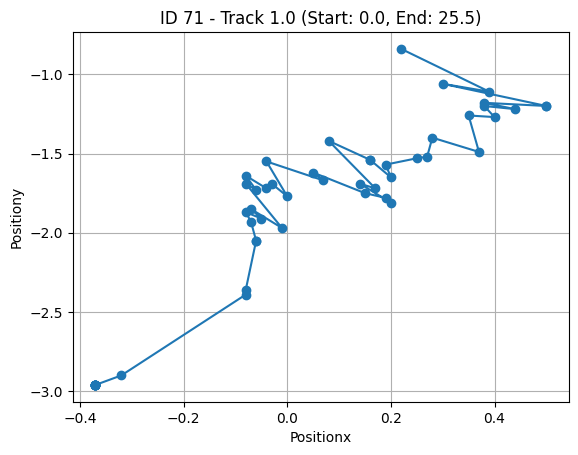

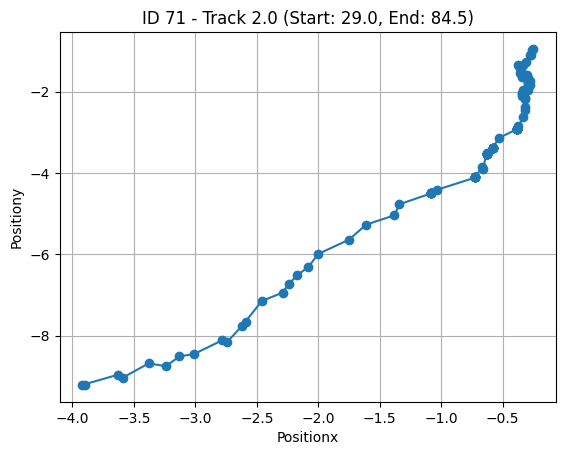

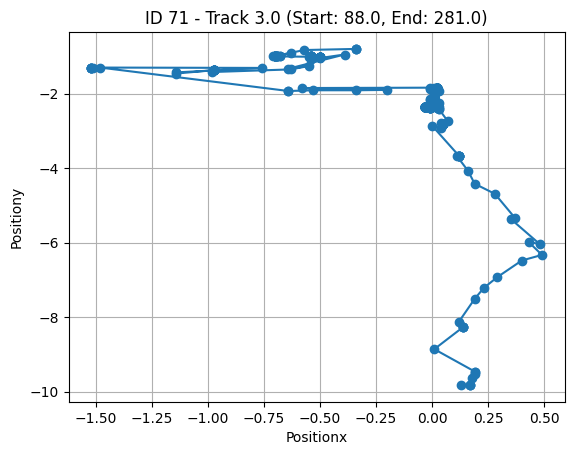

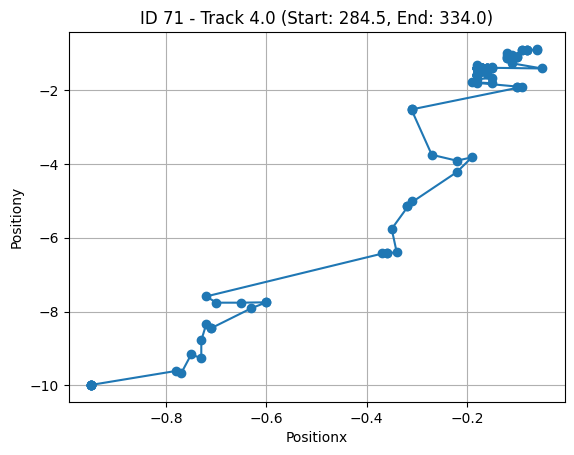

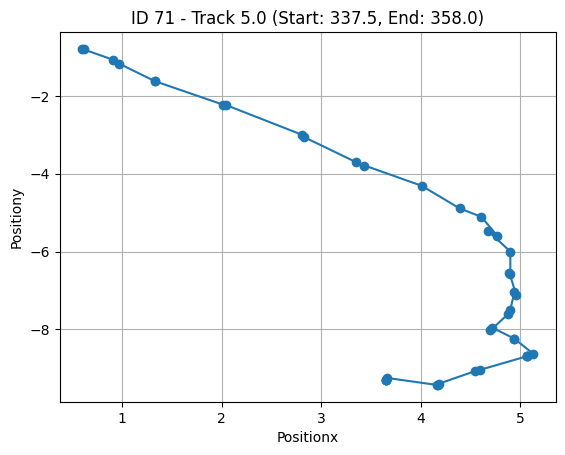

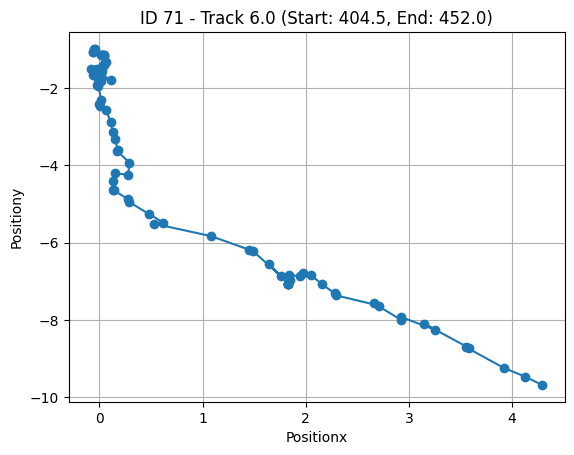

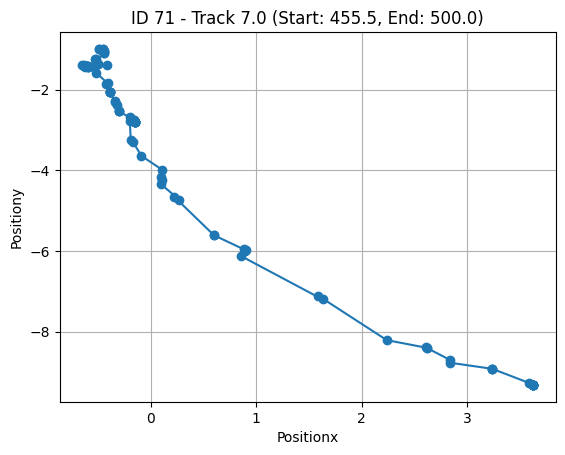

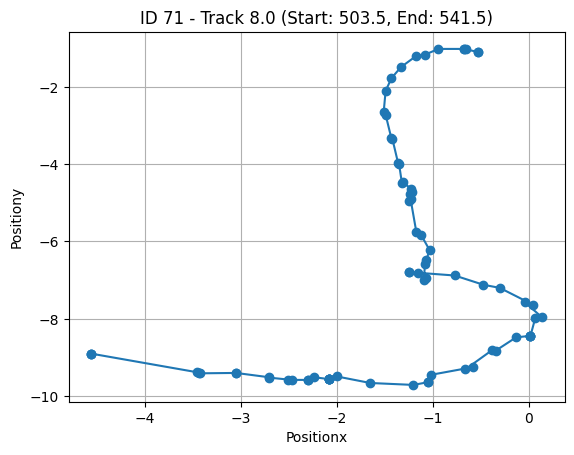

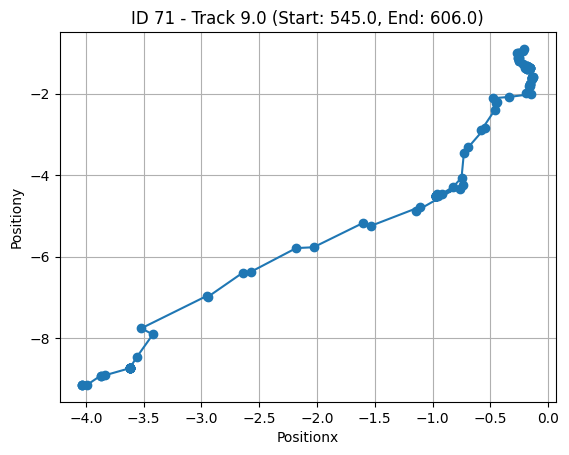

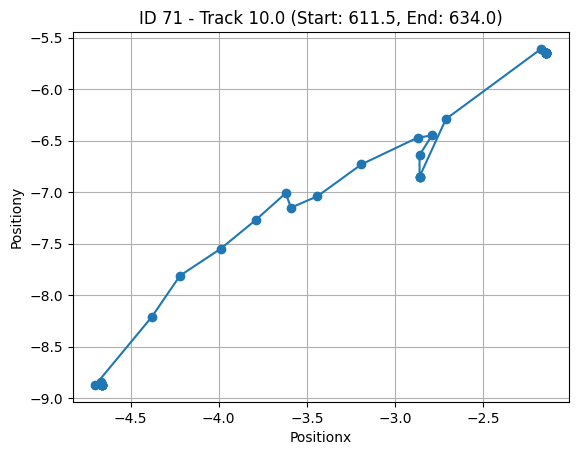

In [15]:
# 排除没有 Label 值的行
data_with_labels = data.dropna(subset=['Label'])

# 找到每一个 Label 的开始和结束时间
label_times = data_with_labels.groupby('Label')['Time'].agg(['min', 'max']).reset_index()

# 创建一个列表来存储所有轨迹图
figures = []

# 为每个轨迹生成二维图并显示
for label in label_times['Label'].unique():
    track_data = data_with_labels[data_with_labels['Label'] == label]
    
    # 跳过没有有效数据的轨迹
    if track_data.empty:
        continue
    
    # 删除包含 NaN 值的行
    track_data = track_data.dropna(subset=['Positionx', 'Positiony'])

    start_time = label_times[label_times['Label'] == label]['min'].values[0]
    end_time = label_times[label_times['Label'] == label]['max'].values[0]
    participant_id = track_data['ID'].values[0]
    
    fig, ax = plt.subplots()
    ax.plot(track_data['Positionx'], track_data['Positiony'], marker='o')
    ax.set_title(f'ID {participant_id} - Track {label} (Start: {start_time}, End: {end_time})')
    ax.set_xlabel('Positionx')
    ax.set_ylabel('Positiony')
    ax.grid(True)